# Bayesian Optimization Workshop: <BR>from hyperparameters optimization to Neural architecture search (NAS) 

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lmassaron/kaggledays-2019-gbdt/blob/master/skopt_workshop_part1.ipynb)


## Instructors
* Luca Massaron [@lmassaron](https://www.linkedin.com/in/lmassaron/) - Data Scientist / Author / Google Developer Expert in Machine Learning

## About the workshop
In this workshop we demonstrate how to use different optimization approaches based on [Scikit-Optimize](https://github.com/scikit-optimize/scikit-optimize), a library built on top of NumPy, SciPy and Scikit-Learn, and we present an easy and fast approach to set them ready and usable.

In the first part, we start from trying to optimize Gradient Boosting Decision Trees (GBDT), which presently represent the state of the art for building predictors for flat table data. However, GBDT seldom perform the best out-of-the-box (using default values) because of the many hyper-parameters to tune. Especially in the most recent GBDT implementations, such as LightGBM, the over-sophistication of hyper-parameters renders finding the optimal settings by hand or simple grid search difficult because of high combinatorial complexity and long running times for experiments.

In the second part, we try to leverage what we have learned so far and challenge the Neural Architecture Search (NAS) problem.

## Prerequisites
You should be aware of the role and importance of hyper-parameter optimization in machine learning.  


## Dealing with the Tutorial Material
In order to make the workshop easily accessible, we are prepared cloud access:
* Using [Google Colab](https://colab.research.google.com/github/lmassaron/kaggledays-2019-gbdt/blob/master/skopt_workshop.ipynb)

## References
* [Random Optimization](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf) (BERGSTRA, James; BENGIO, Yoshua. Random search for hyper-parameter optimization. Journal of Machine Learning Research, 2012, 13.Feb: 281-305.) 
* [Bayesian Optimization](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf) (SNOEK, Jasper; LAROCHELLE, Hugo; ADAMS, Ryan P. Practical bayesian optimization of machine learning algorithms. In: Advances in neural information processing systems. 2012. p. 2951-2959)

For a brief introduction about the key models we will be using during this works we suggest consulting: BOSCHETTI, Alberto; MASSARON, Luca. Python data science essentials. Packt Publishing Ltd, 3rd ed., 2018

# PART I : Optimizing hyper-parameters

The first topic of this workshop aims to illustrate how to best optimize the hyperparameters of a gradient boosting model (lightGBM before all, but also XGBoost and CatBoost) in a performing and efficient way. We will also compare the strong and weak points of different tuning approaches, such grid-search, random search and bayesian optimization by Scikit-optimize.

Leaving apart grid-search (feasible only when the space of experiments is limited), the usual choice for the practitioner is to apply random search optimization or try some [Bayesian Optimization](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf) (BO) technique, which require a more complex setup. 

As for as BO, there are quite a few choices (for instance Hyperopt) but we decided for Scikit-Optimize, or skopt, because it is a simple and efficient library to minimize (very) expensive and noisy black-box functions and it works with an API similar to Scikit-learn. It can be found at https://github.com/scikit-optimize/scikit-optimize/

In [0]:
# Installing the most recent version of skopt directly from Github
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

  Cloning https://github.com/scikit-optimize/scikit-optimize.git to c:\users\luca\appdata\local\temp\pip-req-build-3q7uxgvk
  Running setup.py bdist_wheel for scikit-optimize: started
  Running setup.py bdist_wheel for scikit-optimize: finished with status 'done'
  Stored in directory: C:\Users\Luca\AppData\Local\Temp\pip-ephem-wheel-cache-verq8ue2\wheels\11\6f\86\2b772172db85ad0b4487d67e325e535ee8e7782b2a1dfcadf5
Successfully built scikit-optimize


In [0]:
# Assuring you have the most recent CatBoost release
!pip install catboost -U

Requirement already up-to-date: catboost in c:\users\luca\anaconda3\lib\site-packages (0.13.1)


In [0]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Our example dataset
from sklearn.datasets import load_boston

# Classifiers
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import make_scorer

# Plotting
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

Optimizing hyper-parameters requires time and resources. In order to speed up the demonstration we will be using a toy dataset, the Boston Houseprice dataset for a classification task, to predicted the top 10% most expensive houses.

The dataset presents information collected by the U.S Census Service concerning housing prices and conditions in the area of Boston Mass. Originally found in the [StatLib archive](http://lib.stat.cmu.edu/datasets/boston), the dataset has been used extensively throughout the literature to benchmark machine learning algorithms. The data was originally published by :
> Harrison, D. and Rubinfeld, D.L. Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.

The dataset contains 14 variabile relative to 506 house that were sold in the suburbs of Boston. Among the variables, the 14th, MEDV - Median value of owner-occupied homes in $1000's - is commonly used as a target for regression problems. In our example we will use it for classification, after binarizing it at the 90th percentile (also creating an unbalanced classification problem, since the positive cases are just 10 percent of the total). 

In [0]:
# Uploading the Boston dataset
X, y = load_boston(return_X_y=True)

In [0]:
# Transforming the problem into a classification (unbalanced)
y_bin = (y > np.percentile(y, 90)).astype(int)

In [0]:
#CRIM - per capita crime rate by town
#ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
#INDUS - proportion of non-retail business acres per town.
#CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
#NOX - nitric oxides concentration (parts per 10 million)
#RM - average number of rooms per dwelling
#AGE - proportion of owner-occupied units built prior to 1940
#DIS - weighted distances to five Boston employment centres
#RAD - index of accessibility to radial highways
#TAX - full-value property-tax rate per $10,000
#PTRATIO - pupil-teacher ratio by town
#B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
#LSTAT - % lower status of the population
#MEDV - Median value of owner-occupied homes in $1000's this is our target variable

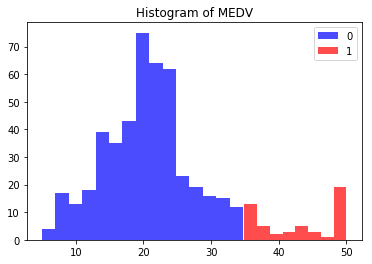

In [0]:
# Histogram highlighting the top 10% we use as a target
plt.hist(y[y <= np.percentile(y, 90)], bins='auto', alpha=0.7, label='0', color='b')
plt.hist(y[y > np.percentile(y, 90)], bins=8, alpha=0.7, label='1', color='r')
plt.title("Histogram of MEDV")
plt.legend(loc='upper right')
plt.show()

# Optimizing Scikit-learn GradientBoostingClassifier

### Gradient Tree Boosting

Gradient Tree boosting or Gradient Boosting Decision Trees (GBDT) is another improved version of boosting (fitting a sequence of weak learners on reweighted versions of the data). Like AdaBoost, GBDT is based on a gradient descent function. The algorithm has proven to be one of the most proficient ones from the ensemble, though it is characterized by an increased variance of estimates, more sensibility to noise in data (both problems could be attenuated by using sub-sampling), and significant computational costs due to nonparallel operations.

Apart from deep learning, gradient boosting is actually the most developed machine learning algorithm. Since Adaboost and the following Gradient Boosting implementation as developed by Jerome Friedman, there appeared various implementations of the algorithms, the most recent ones being XGBoost, LightGBM, and CatBoost

GridSearchCV, RandomizedSearchCV (from Scikit-learn) and BayesSearchCV (from Scikit-optimize) all have the same API. A wrapper can just put together optimization, callbacks, best results reporting and time monitoring.

References:

* [https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8](https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8)

* [https://explained.ai/gradient-boosting/](https://explained.ai/gradient-boosting/)
* [https://www.youtube.com/watch?v=5CWwwtEM2TA](https://www.youtube.com/watch?v=5CWwwtEM2TA)

In [0]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    best_score = optimizer.best_score_
    best_score_std = optimizer.cv_results_['std_test_score'][optimizer.best_index_]
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [0]:
# Converting average precision score into a scorer suitable for model selection
avg_prec = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

In [0]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [0]:
# A Scikit-learn GBM classifier
clf = GradientBoostingClassifier(n_estimators=20, random_state=0)

Grid search exhaustively searches through the hyperparameters and is not feasible in high dimensional space
This is a very simple algorithm and suffers from the curse of dimensionality, though it's embarrassingly parallel.

Here we use, GridSearchCV, a function from Scikit-learn.

In [0]:
# GridSearchCV needs a predefined plan of the experiments
grid_search = GridSearchCV(clf, 
                           param_grid={"learning_rate": [0.01, 1.0],
                                       "n_estimators": [10, 500],
                                       "subsample": [1.0, 0.5],
                                       "min_samples_split": [2, 10],
                                       "min_samples_leaf": [1, 10],
                                       "max_features": ['sqrt', 'log2', None]
                                       },
                           n_jobs=-1,
                           cv=skf,
                           scoring=avg_prec,
                           iid=False, # just return the average score across folds
                           return_train_score=False)

best_params = report_perf(grid_search, X, y_bin,'GridSearchCV')

GridSearchCV took 59.84 seconds,  candidates checked: 96, best CV score: 0.909 ± 0.072
Best parameters:
{'learning_rate': 0.01,
 'max_features': None,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 500,
 'subsample': 0.5}



Random search, which simply samples the search space randomly, is feasible in high dimensional spaces, and is widely used in practice. The downside of random search, however, is that it doesn’t use information from prior experiments to select the next setting.

You simply need to be lucky to catch the right hyper-parameters, or just try as much as you can ;-).

In fact, the 2×Random Search is the Random Search algorithm when it was allowed to sample two points for each point the other algorithms evaluated. While some authors have claimed that 2×Random Search is highly competitive with Bayesian Optimization methods, a [study by Google](http://delivery.acm.org/10.1145/3100000/3098043/p1487-golovin.pdf) (GOLOVIN, Daniel, et al. Google vizier: A service for black-box optimization. In: Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. ACM, 2017. p. 1487-1495) suggests that this is only true when the dimensionality of the problem is sufficiently high (e.g., over 16)

RandomizedSearchCV is a function from Scikit-learn, though skopt has it own random optimizer, *[dummy_minimize](https://scikit-optimize.github.io/#skopt.dummy_minimize)*.

In [0]:
# RandomizedSearchCV needs the distribution of the experiments to be tested
# If you can provide the right distribution, the sampling will lead to faster and better results.

random_search = RandomizedSearchCV(clf, 
                                   param_distributions={"learning_rate": uniform(0.01, 1.0),
                                                        "n_estimators": randint(10, 500),
                                                        "subsample": uniform(0.5, 0.5),
                                                        "min_samples_split": randint(2, 10),
                                                        "min_samples_leaf": randint(1, 10),
                                                        "max_features": ['sqrt', 'log2', None]
                                       },
                                   n_iter=40,
                                   n_jobs=-1,
                                   cv=skf,
                                   scoring=avg_prec,
                                   iid=False, # just return the average score across folds
                                   return_train_score=False,
                                   random_state=0)

best_params = report_perf(random_search, X, y_bin, 'RandomizedSearchCV')

RandomizedSearchCV took 22.92 seconds,  candidates checked: 40, best CV score: 0.927 ± 0.097
Best parameters:
{'learning_rate': 0.10237388946089819,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 9,
 'n_estimators': 384,
 'subsample': 0.8266004099285669}



After examining the classical and most known approaches, it is time to dwelve into Bayesian optimization.

Bayesian optimization is behind [Google Cloud Machine Learning Engine](https://cloud.google.com/blog/products/gcp/hyperparameter-tuning-cloud-machine-learning-engine-using-bayesian-optimization) services.

The key idea behind Bayesian optimization is that we optimize a proxy function instead than the true objective function (what actually grid search and random search both do). This holds if testing the true objective function is costly (if it is not, then we simply go for random search :-))

Bayesian search balances exploration against exploitation. At start it randomly explores, doing so it builds up a surrogate function of the objective. Based on that surrogate function it exploits an initial approximate knowledge of how the predictor works in order to sample more useful examples and minimize the cost function at a global level, not a local one.

As the Bayesian part of the title suggests, we use priors in order to make smarter decisions about sampling during optimizing in order to reach a minimization faster by limiting the number of evaluations we need to make.

Bayesian Optimization uses an acquisition function to tell us how promising an observation will be.
In fact, to rule the tradeoff between exploration and exploitation, the algorithm defines an acquisition function that provides a single measure of how useful it would be to try any given point.

From the figure taken from [Skopt API documentation](https://scikit-optimize.github.io/notebooks/bayesian-optimization.html), you can figure out that the surrogate function (the green dotted line, whose error band is represented by the light green area) has somehow approximated the true cost function (the red dotted line):

![figure_1](https://scikit-optimize.github.io/notebooks/bayesian-optimization_files/bayesian-optimization_21_0.png)

The observations supporting the construction of the surrogate function are not randomly sparse around, because, through an acquisition function (in a gaussian processes it is a function guiding the selection of the next evaluation points), they have been picked as the most useful examples in order to guess how to minimize the cost function.

In respect of a random optimization, a bayesian optimization is more of an educated guess, then, first sampling randomly, but then focussing on the most important combination of hyper-parameters in order to figure out, first the surrogate function of the cost function, then the global minimum of the cost function:

![figure_2](https://scikit-optimize.github.io/notebooks/bayesian-optimization_files/bayesian-optimization_18_1.png)

Gaussian process (GP) is one of the possible ways to build a surrogate function: it consists of a distribution on functions.
Originally GPs were developed to help search for gold ([kriging](https://en.wikipedia.org/wiki/Kriging)). Please note that the approach is closely related to the statistical ideas in the optimal design of experiments.
In a gaussian process, based on a distribution of functions resembling the true cost function, the alogorithm operates in:

* Exploration -> seeking points and areas on the optimization surface with high variance
* Exploitation -> seeking points with low mean

This is done by a second, specialized function, the acquisition function.

Other approaches are 1) ensembles of decision trees 2) Tree of Parzen Estimators (TPE used by [Hyperopt](http://hyperopt.github.io/hyperopt/) 
another Bayesian optimization package package) 

Gaussian Processes are just models, and they're much more like k-nearest neighbors and linear regression than may at first be apparent. If you want to understand more of GPs, you can read the post: [https://planspace.org/20181226-gaussian_processes_are_not_so_fancy/](https://planspace.org/20181226-gaussian_processes_are_not_so_fancy)by Aaron Schumacher.

In [0]:
# also BayesSearchCV needs to work on the distributions of the experiments but it is less sensible to them

search_spaces = {"learning_rate": Real(0.01, 1.0),
                 "n_estimators": Integer(10, 500),
                 "subsample": Real(0.5, 1.0),
                 "min_samples_split": Integer(2, 10),
                 "min_samples_leaf": Integer(1, 10),
                 "max_features": Categorical(categories=['sqrt', 'log2', None])}

for baseEstimator in ['GP', 'RF', 'ET', 'GBRT']:
    opt = BayesSearchCV(clf,
                        search_spaces,
                        scoring=avg_prec,
                        cv=skf,
                        n_iter=40,
                        n_jobs=-1,
                        return_train_score=False,
                        optimizer_kwargs={'base_estimator': baseEstimator},
                        random_state=4)
    
    best_params = report_perf(opt, X, y_bin,'BayesSearchCV_'+baseEstimator)

BayesSearchCV_GP took 138.81 seconds,  candidates checked: 40, best CV score: 0.928 ± 0.062
Best parameters:
{'learning_rate': 0.7184419933944712,
 'max_features': 'log2',
 'min_samples_leaf': 10,
 'min_samples_split': 3,
 'n_estimators': 347,
 'subsample': 1.0}

BayesSearchCV_RF took 124.22 seconds,  candidates checked: 40, best CV score: 0.945 ± 0.051
Best parameters:
{'learning_rate': 0.6049627162690525,
 'max_features': 'sqrt',
 'min_samples_leaf': 9,
 'min_samples_split': 10,
 'n_estimators': 485,
 'subsample': 0.6024816853254407}

BayesSearchCV_ET took 101.51 seconds,  candidates checked: 40, best CV score: 0.933 ± 0.059
Best parameters:
{'learning_rate': 0.39752021916372565,
 'max_features': None,
 'min_samples_leaf': 6,
 'min_samples_split': 9,
 'n_estimators': 78,
 'subsample': 0.7687211202072857}

BayesSearchCV_GBRT took 95.73 seconds,  candidates checked: 40, best CV score: 0.933 ± 0.068
Best parameters:
{'learning_rate': 0.42127830500668484,
 'max_features': 'log2',
 'min_s

## Searching more complex spaces
If you have multiple models to optimize, you can leverage the *Pipeline* command in order to search different search spaces based on different models. That's requires to access to the hyper-parameters accordingly to *Pipeline* specifications, anyway.

In [0]:
# Initialize a pipeline with a model
pipe = Pipeline([('model', GradientBoostingClassifier(n_estimators=20, random_state=0))])

# Define search space for GBM;
search_space_GBM = {"model": Categorical([GradientBoostingClassifier(n_estimators=20, random_state=0)]),
                    "model__learning_rate": Real(0.01, 1.0),
                    "model__n_estimators": Integer(10, 500),
                    "model__subsample": Real(0.5, 1.0),
                    "model__min_samples_split": Integer(2, 10),
                    "model__min_samples_leaf": Integer(1, 10),
                    "model__max_features": Categorical(categories=['sqrt', 'log2', None])}

# Define search space for RF
search_space_RF  = {"model": Categorical([RandomForestClassifier(n_estimators=20, random_state=0)]),
                    "model__n_estimators": Integer(10, 200),
                    "model__min_samples_split": Integer(2, 10),
                    "model__min_samples_leaf": Integer(1, 10),
                    "model__max_features": Categorical(categories=['sqrt', 'log2', None])}

opt = BayesSearchCV(pipe,
                        search_spaces=[(search_space_GBM, 20), (search_space_RF, 20)],
                        scoring=avg_prec,
                        cv=skf,
                        n_jobs=-1,
                        return_train_score=False,
                        optimizer_kwargs={'base_estimator': 'GP'},
                        random_state=4)
    
best_params = report_perf(opt, X, y_bin,'BayesSearchCV_GP')

C:\Users\Luca\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Luca\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Luca\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Luca\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Luca\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Luca\Anacon

BayesSearchCV_GP took 106.81 seconds,  candidates checked: 40, best CV score: 0.920 ± 0.077
Best parameters:
{'model': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2554001338861434, loss='deviance',
              max_depth=3, max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=6, min_samples_split=7,
              min_weight_fraction_leaf=0.0, n_estimators=225,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=0.7900947461882674, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'model__learning_rate': 0.2554001338861434,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 6,
 'model__min_samples_split': 7,
 'model__n_estimators': 225,
 'model__subsample': 0.7900947461882674}



## Controlling the time cost of Bayesian optimization

Running a single LightGBM model could take long time and in a Kaggle competition time is often a luxury. 

*DeadlineStopper* and *DeltaXStopper* are skopt callbacks that control the total time spent and the improvement of a BayesSearchCV (in our implementation to be called with *report_perf*, using the parameter *callbacks=[]*). 

Anyway, sometimes it is easier to control manually the optimization steps, hence the usage of low-level optimizers. 

We start defining a custom callback, using a different approach to search spaces (a list instead of a dictionary), and to manually create our objective function to be minimized.

In our custom callback, we print the last evaluation point (so you know what's happening) and the best score and parameters foudn up so far. We also record the list of explored points (*x0*) and their relative results (*y0*). This will help us to reprise the learning at a later time. 

In [0]:
counter = 0
def onstep(res):
    global counter
    x0 = res.x_iters   # List of input points
    y0 = res.func_vals # Evaluation of input points
    print('Last eval: ', x0[-1], 
          ' - Score ', y0[-1])
    print('Current iter: ', counter, 
          ' - Score ', res.fun, 
          ' - Args: ', res.x)
    joblib.dump((x0, y0), 'checkpoint.pkl') # Saving a checkpoint to disk
    counter += 1

# Our search space
dimensions = [Real(0.01, 1.0, name="learning_rate"),
              Integer(10, 500, name="n_estimators"),
              Real(0.5, 1.0, name="subsample"),
              Integer(2, 10, name="min_samples_split"),
              Integer(1, 10, name="min_samples_leaf"),
              Categorical(categories=['sqrt', 'log2', None], name="max_features")]

# The objective function to be minimized
def make_objective(model, X, y, space, cv, scoring):
    # This decorator converts your objective function with named arguments into one that
    # accepts a list as argument, while doing the conversion automatically.
    @use_named_args(space) 
    def objective(**params):
        model.set_params(**params)
        return -np.mean(cross_val_score(model, 
                                        X, y, 
                                        cv=cv, 
                                        n_jobs=-1,
                                        scoring=scoring))

    return objective

objective = make_objective(clf,
                           X, y_bin,
                           space=dimensions,
                           cv=skf,
                           scoring=avg_prec)

There are different low-level optimizers that can be used for the purpose:
* **gp_minimize** Bayesian optimization using Gaussian Processes.
* **forest_minimize** Sequential optimisation using decision trees
* **gbrt_minimize** Sequential optimization using gradient boosted trees
* **dummy_minimize** Random search by uniform sampling within the given bounds (a replacement for Scikit-learn's RandomSearch)

Each optimizer has its own parameters, so they cannot be just automatically switched, though they share most of the key parameters.

Here we encounter also a new parameter, **acq_func**, useful for defining how the acquisition function should behave, that is, if to take as minimum the lower confidence bound, the minimum expected value or probability (the suggested default is usually a good choice).

In [0]:
gp_round = gp_minimize(func=objective,
                       dimensions=dimensions,
                       acq_func='gp_hedge', # Defining what to minimize 
                       n_calls=10,
                       callback=[onstep],
                       random_state=22)

Last eval:  [0.7049433514242192, 368, 0.8187395776032731, 8, 9, None]  - Score  -0.9053516521792384
Current iter:  0  - Score  -0.9053516521792384  - Args:  [0.7049433514242192, 368, 0.8187395776032731, 8, 9, None]
Last eval:  [0.24229127648570348, 16, 0.7320268705932458, 8, 2, 'sqrt']  - Score  -0.8892368868276309
Current iter:  1  - Score  -0.9053516521792384  - Args:  [0.7049433514242192, 368, 0.8187395776032731, 8, 9, None]
Last eval:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']  - Score  -0.9234068462086364
Current iter:  2  - Score  -0.9234068462086364  - Args:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']
Last eval:  [0.010263121534902437, 442, 0.972884851277688, 9, 2, 'sqrt']  - Score  -0.9049683094683093
Current iter:  3  - Score  -0.9234068462086364  - Args:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']
Last eval:  [0.8875384524348883, 205, 0.9771110531385809, 8, 8, None]  - Score  -0.8977127929278959
Current iter:  4  - Score  -0

In [0]:
x0, y0 = joblib.load('checkpoint.pkl')

gp_round = gp_minimize(func=objective,
                       x0=x0,              # already examined values for x
                       y0=y0,              # observed values for x0
                       dimensions=dimensions,
                       acq_func='gp_hedge', # Expected Improvement.
                       n_calls=10,
                       callback=[onstep],
                       random_state=0)

Last eval:  [0.7856253596534273, 448, 0.7012180692236435, 9, 8, 'sqrt']  - Score  -0.753150122881838
Current iter:  10  - Score  -0.9234068462086364  - Args:  [0.09808017080760961, 436, 0.721036739670265, 3, 4, 'log2']
Last eval:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']  - Score  -0.9433474858474857
Current iter:  11  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.3045592604790276, 38, 0.6363281472900566, 6, 8, 'log2']  - Score  -0.9160759254036765
Current iter:  12  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.39885694813982153, 420, 0.6686980802086342, 7, 4, None]  - Score  -0.8992387417077818
Current iter:  13  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.14894727260851873, 436, 0.7368040226368553, 8, 6, None]  - Score  -0.9172835775335775
Current iter:  14  - S

In [0]:
best_parameters = gp_round.x
best_result = gp_round.fun
print(best_parameters, best_result)

[0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2'] -0.9433474858474857


In conclusion, just keep in mind a few points from the workshop:

* Bayesian Optimization has its own hyper-parameters (therefore use defaults, [unless you know what you doing](https://i0.kym-cdn.com/entries/icons/original/000/008/342/ihave.jpg))

* Experiments are run sequentially (skopt can leverage some parallelism, though), having multiple cores is helpful for your learning algorithm,but Bayesian Optimization will always be slower than Random Search. Use it only when needed.

* Packages are not all that friendly (hence the workshop :-)) but you can reuse some simple wrappers re-adaptable to being used in different Kaggle competitions.

## Hacking Bayesian optimization

In [0]:
# Our search space

dimensions = [Real(0.01, 1.0, name="learning_rate"),
              Integer(10, 500, name="n_estimators"),
              Real(0.5, 1.0, name="subsample"),
              Integer(2, 10, name="min_samples_split"),
              Integer(1, 10, name="min_samples_leaf"),
              Categorical(categories=['sqrt', 'log2', None], name="max_features")]

rand_opt_dims = {"learning_rate": uniform(0.01, 1.0),
                 "n_estimators": randint(10, 500),
                 "subsample": uniform(0.5, 0.5),
                 "min_samples_split": randint(2, 10),
                 "min_samples_leaf": randint(1, 10),
                 "max_features": ['sqrt', 'log2', None]
                }

In [0]:
# Converting average precision score into a scorer suitable for model selection
avg_prec = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)

# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# A Scikit-learn GBM classifier
clf = GradientBoostingClassifier(n_estimators=20, random_state=0)

random_search = RandomizedSearchCV(clf, 
                                   param_distributions=rand_opt_dims, 
                                   n_iter=60,
                                   n_jobs=-1,
                                   cv=skf,
                                   scoring=avg_prec,
                                   iid=False, # just return the average score across folds
                                   return_train_score=False,
                                   random_state=0)

random_search.fit(X, y_bin)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
          error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=60, n_jobs=-1,
          param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000C578400>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000C5584A8>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000C558668>, 'min_...istn_infrastructure.rv_frozen object at 0x000000000C1323C8>, 'max_features': ['sqrt', 'l

In [0]:
print("Best result by random search: %0.5f" % random_search.best_score_)

Best result by random search: 0.93595


In [0]:
random_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'param_subsample', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [0]:
params = ["learning_rate", "n_estimators", "subsample", "min_samples_split", "min_samples_leaf", "max_features"]
x0 = [[ex[p] for p in params] for ex in random_search.cv_results_['params']]
y0 = random_search.cv_results_['mean_test_score'] * -1

In [0]:
# The objective function to be minimized
def make_objective(model, X, y, space, cv, scoring):
    # This decorator converts your objective function with named arguments into one that
    # accepts a list as argument, while doing the conversion automatically.
    @use_named_args(space) 
    def objective(**params):
        model.set_params(**params)
        return -np.mean(cross_val_score(model, 
                                        X, y, 
                                        cv=cv, 
                                        n_jobs=-1,
                                        scoring=scoring))

    return objective

objective = make_objective(clf,
                           X, y_bin,
                           space=dimensions,
                           cv=skf,
                           scoring=avg_prec)


gp_round = gp_minimize(func=objective,
                       x0=x0,              # already examined values for x
                       y0=y0,              # observed values for x0
                       dimensions=dimensions,
                       acq_func='gp_hedge', # Expected Improvement.
                       n_calls=10,
                       callback=[onstep],
                       random_state=0)

Last eval:  [0.11029394226549781, 177, 0.834958273295455, 8, 7, 'log2']  - Score  -0.922229074846722
Current iter:  21  - Score  -0.9359512756354189  - Args:  [0.2223904988903086, 406, 0.784786767287369, 7, 6, None]
Last eval:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']  - Score  -0.9433474858474857
Current iter:  22  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.3045592604790276, 38, 0.6363281472900566, 6, 8, 'log2']  - Score  -0.9160759254036765
Current iter:  23  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.39885694813982153, 420, 0.6686980802086342, 7, 4, None]  - Score  -0.8992387417077818
Current iter:  24  - Score  -0.9433474858474857  - Args:  [0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2']
Last eval:  [0.14894727260851873, 436, 0.7368040226368553, 8, 6, None]  - Score  -0.9172835775335775
Current iter:  25  - Scor

In [0]:
best_parameters = gp_round.x
best_result = gp_round.fun
print(best_parameters, best_result)

[0.5969161720427683, 424, 0.9289728088113784, 9, 7, 'log2'] -0.9433474858474857
